# Introduction

### Project Abstract

### Figure illustrating workflow (Ruoyu)

See below for a brief summary illustration of the workflow for this project:

<img src="./img/workflow.jpg" width="1000">

# Data (Zhengyi)

# Pre-processing Pipeline (All, specific TBD)

### Functions

# Feature Spaces

### TF-IDF (Ruoyu)

Term Frequency-Inverse Document Frequency(TF-IDF) is defined by 

\begin{align*}
    \text{TF}(t) &= \frac{\text{Occurence of term $t$ in document}}{\text{Total number of terms in document}}\\
    \text{IDF}(t) &= \log\left(
        \frac{
            \text{Total number of documents}
        }{
            \text{Number of documents containing term $t$}
        }
    \right)\\
    \text{TF-IDF}(t)&=\text{TF}(t)\cdot \text{IDF}(t)
\end{align*}

Intuition: Relative importance $\times$ relative offset

### Word2Vec (Mike)

Pre-trained in library vs. fit on own document

### Extra features

- `exclaim_freq`: frequency of exclamation points:

\begin{align*}
\text{exclaim\_freq(document)} &= \frac{\text{Count}(``!")}{\sum_{\text{term}\in \text{doc}}\text{len(term)}}\\
e.g.\quad \text{exclaim\_freq(``I! like apples!!'')}
&=\frac{3}{2 + 4 + 8}
\end{align*}

- `mention_count`: count of occurrence of "@Username4525" in a document.

- `cap_freq`: frequency of capitalized letters:

\begin{align*}
\text{cap\_freq(document)} &= \frac{\text{Count of CAPITALIZED letters}}{\text{len(document)}}\\
e.g.\quad \text{cap\_freq(``I LIKE APPLES'')}
&=1
\end{align*}

# Models

### Naive Bayes (Zhengyi)

### Logistic Regression (Skylar)

### Random Forest (Mike)

### LSTM (Ruoyu, if possible)

# Result and summary

### TODO: create a table containing all accuracy scores, feature space numbers, and models (Skylar)


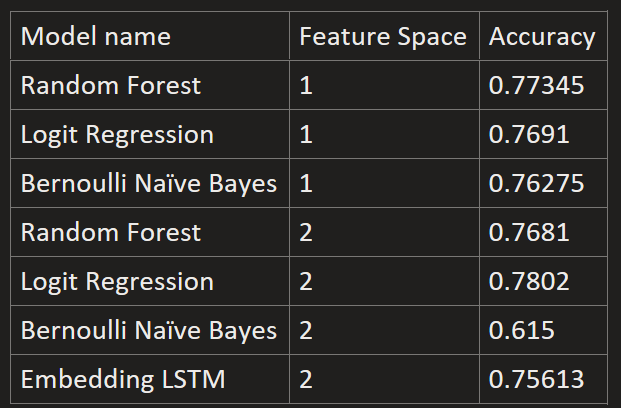